# **CSST 106**

**Verdad, Jane Benneth Dione**

**BSCS-4B**

**October 2024**

**Exercise 3**

# **Advanced Feature Extraction and Image Processing**

# Task 1:  Harris Corner Detection

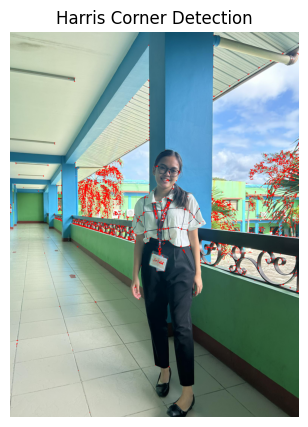

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Load the image
image_path = 'jbdv.jpg'
img = cv2.imread(image_path)
if img is None:
    print("Image not found.")
else:
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Convert to float32 (required by the Harris Corner Detector)
    gray = np.float32(gray)

    #Apply Harris Corner Detection
    dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

    #Dilate corner points for better visibility
    dst = cv2.dilate(dst, None)

    #Highlight corners on the original image
    img[dst > 0.01 * dst.max()] = [0, 0, 255]  # Mark corners with red color

    #Display the result
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Harris Corner Detection")
    plt.axis("off")
    plt.show()


# Task 2: HOG (Histogram of Oriented Gradients) Feature Extraction

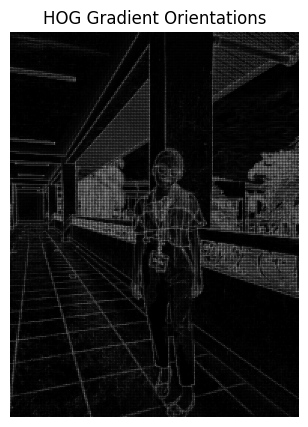

In [36]:
import cv2
import numpy as np
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt

#Load the image
image_path = 'jbdv.jpg'
img = cv2.imread(image_path)
if img is None:
    print("Image not found.")
else:
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Apply HOG Descriptor
    #Use skimage's hog function to compute HOG features and visualize the gradient orientations
    hog_features, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=True, channel_axis=None)

    #Visualize Gradient Orientations
    #Rescale the HOG image for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    #Display the original image and the HOG visualization
    plt.figure(figsize=(5, 5))
    plt.imshow(hog_image_rescaled, cmap="gray")
    plt.title("HOG Gradient Orientations")
    plt.axis("off")
    plt.show()


# Task 3: FAST (Features from Accelerated Segment Test) Keypoint Detection

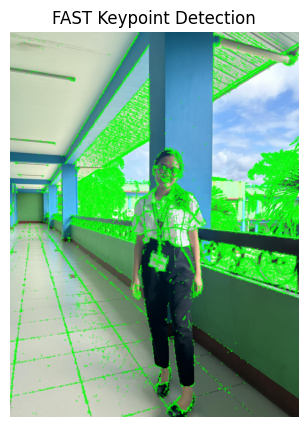

In [38]:
import cv2
import matplotlib.pyplot as plt

#Load the image
image_path = 'jbdv.jpg'
img = cv2.imread(image_path)
if img is None:
    print("Image not found.")
else:
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    #Apply FAST keypoint detector
    #Initialize FAST detector
    fast = cv2.FastFeatureDetector_create()

    #Detect keypoints using FAST
    keypoints = fast.detect(gray, None)

    #Visualize the keypoints
    #Draw keypoints on the original image
    img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, color=(0, 255, 0))

    #Display the result
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
    plt.title("FAST Keypoint Detection")
    plt.axis("off")
    plt.show()


# Task 4: Feature Matching using ORB and FLANN

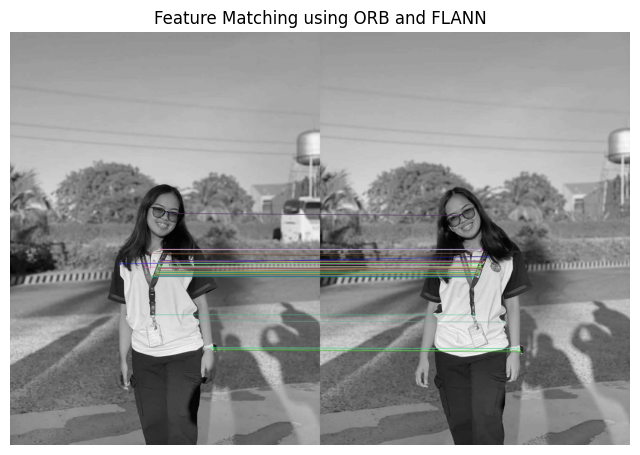

In [39]:
import cv2
import matplotlib.pyplot as plt

#Load the images
image1_path = 'benneth.jpg'
image2_path = 'dione.jpg'

img1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

if img1 is None or img2 is None:
    print("One or both images not found.")
else:
    #Detect keypoints and compute descriptors with ORB
    orb = cv2.ORB_create()

    #Detect keypoints and compute descriptors
    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    #Match features using FLANN-based matcher
    #FLANN parameters for ORB
    index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1)  # LSH
    search_params = dict(checks=50)  # Increase for more accurate matching

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    #Perform matching
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    #Apply the ratio test to retain good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    #Visualize matched features
    #Draw matches between the two images
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    #Display the matched features
    plt.figure(figsize=(8, 8))
    plt.imshow(img_matches)
    plt.title("Feature Matching using ORB and FLANN")
    plt.axis("off")
    plt.show()


# Task 5: Image Segmentation using Watershed Algorithm

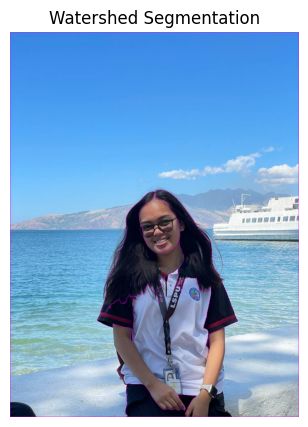

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Load the image
image_path = 'jane.jpg'
img = cv2.imread(image_path)
if img is None:
    print("Image not found.")
else:
    #Convert to grayscale and apply a binary threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    #orphological operations to remove noise and separate regions
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    #Determine the sure background area by dilating the binary image
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    #Use distance transform to find the sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

    #Identify the unknown region by subtracting foreground from background
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    #Marker labeling for watershed
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    #Apply the Watershed algorithm
    markers = cv2.watershed(img, markers)

    #Mark boundaries
    img[markers == -1] = [255, 0, 255]

    #Display the result
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Watershed Segmentation")
    plt.axis("off")
    plt.show()
